In [1]:
# load packages
import os
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import pcntoolkit as pcn
import pickle

from scipy.stats import shapiro

from enigmatoolbox.utils.parcellation import parcel_to_surface
from enigmatoolbox.plotting import plot_cortical, plot_subcortical
from enigmatoolbox.utils.useful import reorder_sctx

from pcntoolkit.normative import estimate, predict, evaluate
from pcntoolkit.util.utils import compute_MSLL, create_design_matrix

ext_scripts_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO/braincharts/scripts')
os.chdir(ext_scripts_dir)

from nm_utils import remove_bad_subjects, load_2d

code_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO/code')
os.chdir(code_dir)

# importing custom functions
import clinics_desc_functions as custom
from clinics_desc_functions import prepare_data, plot_quality, trajectory_plotting, dk_roi_viz, load_clinics, en_qc, pretrained_adapt_small, set_seed

# set seed
set_seed()

# formatiing
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}


Random seed 42 has been set.


In [2]:
# where things are
main_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO')
models_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO/models/zscores_comparison_long')
os.makedirs(models_dir, exist_ok=True)
controls_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO/models/control_stability_long')
patients_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO/models/pretrained_long')
cdata_dir = ('/home/barbora/Documents/Projects/2021_06_AZV_ESO/data')
fsdata_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO/fs_stats')
bdata_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO/backup/fit_external_long')
images_dir = os.path.join(models_dir,'img')
os.makedirs(images_dir, exist_ok=True)
pretrained_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO/braincharts')

In [3]:
# get basic parameters for pretrained models
model_name, site_names, site_ids_tr, idp_ids = custom.pretrained_ini()

In [4]:
###
# longitudinal paired controls
###
#v11_cf = custom.idp_concat(os.path.join(main_dir,'models','adaptation_comparison_paired','V1'), 'v1_Z.txt', idp_ids,  'v11_cont_z.csv', t_dir= models_dir)
#v12_cf = custom.idp_concat(os.path.join(main_dir,'models','adaptation_comparison_paired','V1'), 'v2_Z.txt', idp_ids,  'v12_cont_z.csv', t_dir= models_dir)

v11_cf = custom.idp_concat(controls_dir, 'v1_Z.txt', idp_ids,  'v11_cont_z.csv', t_dir= models_dir)
v12_cf = custom.idp_concat(controls_dir, 'v2_Z.txt', idp_ids,  'v12_cont_z.csv', t_dir= models_dir)

# concatenate over idps and load
v1_cont_z = pd.read_csv(v11_cf, sep = ' ', index_col=0)
v2_cont_z = pd.read_csv(v12_cf, sep = ' ', index_col=0)

# load original control data with clinics
v1_cont_clin = pd.read_csv(os.path.join(controls_dir,'v1_common.csv'),index_col=0, sep = ' ', usecols=range(0,9))
v2_cont_clin = pd.read_csv(os.path.join(controls_dir,'v2_common.csv'),index_col=0, sep = ' ', usecols=range(0,9))

v1_cont_orig = pd.read_csv(os.path.join(controls_dir,'v1_common.csv'),index_col=0, sep = ' ')
v2_cont_orig = pd.read_csv(os.path.join(controls_dir,'v2_common.csv'),index_col=0, sep = ' ')

# change index before concatenation
v1_cont_z.index = v1_cont_clin.index
v2_cont_z.index = v2_cont_clin.index

# concatenate
v1_cont = pd.concat([v1_cont_clin,v1_cont_z],axis=1,join='inner')
v2_cont = pd.concat([v2_cont_clin,v2_cont_z],axis=1,join='inner')


In [5]:
###
# patients
###

v11_pf = custom.idp_concat(os.path.join(patients_dir,'V1'), 'Z_predict.txt', idp_ids,  'v11_pat_z.csv', t_dir= models_dir)
v12_pf = custom.idp_concat(os.path.join(patients_dir,'V2'), 'Z_predict.txt', idp_ids,  'v12_pat_z.csv', t_dir= models_dir)

# concatenate over idps and load
v1_pat_z = pd.read_csv(v11_pf, sep = ' ', index_col=0)
v2_pat_z = pd.read_csv(v12_pf, sep = ' ', index_col=0)

# load clinics
v1_pat_clin = pd.read_csv(os.path.join(patients_dir,'v1_pat.txt'), sep=' ', index_col=0, usecols=range(0,9))
v2_pat_clin = pd.read_csv(os.path.join(patients_dir,'v2_pat.txt'), sep=' ', index_col=0, usecols=range(0,9))

v1_pat_orig_all = pd.read_csv(os.path.join(patients_dir,'v1_pat.txt'), sep=' ', index_col=0)
v2_pat_orig_all = pd.read_csv(os.path.join(patients_dir,'v2_pat.txt'), sep=' ', index_col=0)

# DON'T RUN FOR LONGIT DATA
# delete visit from index
#v1_pat_clin.index = v1_pat_clin.index.str.slice_replace(start=-2, repl='').to_numpy()
#v2_pat_clin.index = v2_pat_clin.index.str.slice_replace(start=-2, repl='').to_numpy()
#v1_pat_orig_all.index = v1_pat_orig_all.index.str.slice_replace(start=-2, repl='').to_numpy()
#v2_pat_orig_all.index = v2_pat_orig_all.index.str.slice_replace(start=-2, repl='').to_numpy()

# change index before concatenation
v1_pat_z.index = v1_pat_clin.index
v2_pat_z.index = v2_pat_clin.index

# concatenate
v1_pat_all = pd.concat([v1_pat_clin,v1_pat_z],axis=1,join='inner')
v2_pat_all = pd.concat([v2_pat_clin,v2_pat_z],axis=1,join='inner')

# We only want to keep patients with both visits
common = v1_pat_all.index.intersection(v2_pat_all.index)
v1_common_id = np.where(v1_pat_all.index.isin(common))
v2_common_id = np.where(v2_pat_all.index.isin(common))

v1_pat = v1_pat_all.loc[common]
v2_pat = v2_pat_all.loc[common]

v1_pat_orig = v1_pat_orig_all.loc[common]
v2_pat_orig = v2_pat_orig_all.loc[common]

delta_pat = v2_pat['age']-v1_pat['age']


In [10]:
[print(i) for i in v1_cont.index]

C00577
C00579
C00584
C00588
C00590
C00591
C00603
C00604
C00606
C00607
C00608
C00609
C00617
C00626
C00633
C00634
C00638
C00641
C00645
C00678
C00681
C00692
C00698
C00712
C00755
C00764
C00795
C00864
C00869
C00901
C00928
C01015
C01032
C01067
C01077
C01446
C01453
C01454
C01475
C01764
C01777
C01807
C01812
C01825
C01833
C01844
C01851
C01885
C01891
C01892
C01903
C01912
C01919
C01927
C01928
C01934
C01951
C01967
C01977
C01987
C01992
C02010
C02051
C02091
C02128
C02228
C02236
C02245
C02512
C02625


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [6]:
# Finally, compute the differences
col_comp_id = np.where(v1_pat.columns.isin(idp_ids))[0]
cont_diff = (v2_cont.iloc[:,col_comp_id]) - (v1_cont.iloc[:,col_comp_id])
pat_diff = (v2_pat.iloc[:,col_comp_id]) - (v1_pat.iloc[:,col_comp_id])

In [7]:
###
# Load dependencies for plotting
###
# which data columns do we wish to use as covariates? 
#cols_cov = ['age','sex']
# which sex do we want to plot? 
sex = 1 # 1 = male 0 = female
if sex == 0: 
    clr = 'lightcoral'
else:
    clr = 'cadetblue'

v1_plot = v1_pat[v1_pat['sex']==sex]
v2_plot = v2_pat[v2_pat['sex']==sex]

# limits for cubic B-spline basis 
xmin = -5 
xmax = 110
model_name = 'lifespan_57K_82sites'
# Absolute Z treshold above which a sample is considered to be an outlier (without fitting any model)
outlier_thresh = 7

# create dummy data for visualisation
print('configuring dummy data ...')
xx = np.arange(xmin, xmax, 0.5)
X0_dummy = np.zeros((len(xx), 2))
X0_dummy[:,0] = xx # intercept
X0_dummy[:,1] = sex # sex covariate

X_dummy = create_design_matrix(X0_dummy, xmin=xmin, xmax=xmax, site_ids=None, all_sites=site_ids_tr)
cov_file_dummy = os.path.join(models_dir,'cov_bspline_dummy_mean.txt')
np.savetxt(cov_file_dummy, X_dummy)

#X_dummy = pd.read_csv(os.path.join(models_dir,'cov_bspline_dummy_mean.txt'),header=None, sep=' ')
sig_to_plot = pat_diff
#images_dir = os.path.join(models_dir, 'img_normal_noshift_time_nodetrend')
images_dir = os.path.join(models_dir, 'OHBM')
os.makedirs(images_dir, exist_ok=True)

# adjusting done on visit 1
visit_dir = os.path.join(main_dir,'models','pretrained_long')

configuring dummy data ...


In [8]:
###
# Plotting longitudinal "results" of normative models
###

sns.set(style='whitegrid', font_scale=1.5)


for idp_num, idp in enumerate(['Left-Lateral-Ventricle']):#enumerate(idp_ids): #enumerate(['lh_G&S_frontomargin_thickness']):#
    print('Running IDP', idp_num, idp, ':')
    idp_dir = os.path.join(pretrained_dir,'models',model_name, idp)
    #idp_visit_dir = os.path.join(visit_dir,idp)
    os.chdir(visit_dir)
    
    # load the true data points V1
    v1_yhat_te = load_2d(os.path.join(visit_dir,'V1',idp, 'yhat_predict.txt'))
    v1_s2_te = load_2d(os.path.join(visit_dir,'V1',idp, 'ys2_predict.txt'))
    v1_y_te = load_2d(os.path.join(visit_dir,'V1',idp, 'resp_te.txt'))
    v1_bspline = pd.DataFrame(load_2d(os.path.join(visit_dir,'V1',idp, 'cov_bspline_te.txt')))

    # load the true data points V2
    v2_yhat_te = load_2d(os.path.join(visit_dir,'V2',idp, 'yhat_predict.txt'))
    v2_s2_te = load_2d(os.path.join(visit_dir,'V2',idp, 'ys2_predict.txt'))
    v2_y_te = load_2d(os.path.join(visit_dir,'V2',idp, 'resp_te.txt'))
    v2_bspline = pd.DataFrame(load_2d(os.path.join(visit_dir,'V2',idp, 'cov_bspline_te.txt')))

    #########################################################################
    # set up the covariates for the dummy data
    print('Making predictions with dummy covariates (for visualisation)')
    yhat, s2 = predict(cov_file_dummy, 
                       alg = 'blr', 
                       respfile = None, 
                       model_path = os.path.join(idp_dir,'Models'), 
                       outputsuffix = '_dummy')
    
    # load the normative model
    with open(os.path.join(idp_dir,'Models', 'NM_0_0_estimate.pkl'), 'rb') as handle:
        nm = pickle.load(handle) 
    
    # get the warp and warp parameters
    W = nm.blr.warp
    warp_param = nm.blr.hyp[1:nm.blr.warp.get_n_params()+1] 

    # warp dummy predictions to create the plots
    med, pr_int = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param)
    
    # extract the different variance components to visualise
    beta, junk1, junk2 = nm.blr._parse_hyps(nm.blr.hyp, X_dummy)
    s2n = 1/beta # variation (aleatoric uncertainty)
    s2s = s2-s2n # modelling uncertainty (epistemic uncertainty)
    #########################################################################

    #  warp predictions for the true data and compute evaluation metrics
    v1_med_te = W.warp_predictions(np.squeeze(v1_yhat_te), np.squeeze(v1_s2_te), warp_param)[0]
    v1_med_te = v1_med_te[:, np.newaxis]

    v2_med_te = W.warp_predictions(np.squeeze(v2_yhat_te), np.squeeze(v2_s2_te), warp_param)[0]
    v2_med_te = v2_med_te[:, np.newaxis]

    # load the adaptation data
    y_ad = load_2d(os.path.join(visit_dir,'V1',idp, 'resp_ad.txt'))
    X_ad = load_2d(os.path.join(visit_dir,'V1',idp, 'cov_bspline_ad.txt'))

    # pick indicies for adaptation
    idx_a = np.where(X_ad[:,2]==sex)[0] # sex index for adaptation set

    v1_idx = np.where(v1_pat['sex'] == sex)[0]
    v2_idx = np.where(v2_pat['sex'] == sex)[0]

    # y_te = np.array([v1_y_te[v1_idx],v1_y_te[v1_idx]])

    # adjust and rescale the data
    v1_y_te_rescaled, v1_s2_rescaled = nm.blr.predict_and_adjust(nm.blr.hyp, 
                                                            X_ad[idx_a,:], 
                                                            np.squeeze(y_ad[idx_a]), 
                                                            Xs=None, 
                                                            ys=np.squeeze(v1_y_te[v1_idx]))
    
    v1_y_te_rescaled_f = os.path.join(visit_dir, 'V1', idp, 'v1_y_rescaled_common'+str(sex)+'.txt')
    np.savetxt(v1_y_te_rescaled_f,v1_y_te_rescaled)

    v2_y_te_rescaled, v2_s2_rescaled = nm.blr.predict_and_adjust(nm.blr.hyp, 
                                                            X_ad[idx_a,:], 
                                                            np.squeeze(y_ad[idx_a]), 
                                                            Xs=None, 
                                                            ys=np.squeeze(v2_y_te[v2_idx]))
    
    # save transformed predictions so that we don't have to sompute this ever again
    v2_y_te_rescaled_f = os.path.join(visit_dir, 'V2', idp, 'v2_y_rescaled_common'+str(sex)+'.txt')
    np.savetxt(v2_y_te_rescaled_f,v2_y_te_rescaled)

    plt.figure(figsize=(8,6))

    # plot the median of the dummy data
    plt.plot(xx, med, clr, linewidth=3)
    
    # fill the gaps in between the centiles
    junk, pr_int25 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.25,0.75])
    junk, pr_int95 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.05,0.95])
    junk, pr_int99 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.01,0.99])
    plt.fill_between(xx, pr_int25[:,0], pr_int25[:,1], alpha = 0.1,color=clr)
    plt.fill_between(xx, pr_int95[:,0], pr_int95[:,1], alpha = 0.1,color=clr)
    plt.fill_between(xx, pr_int99[:,0], pr_int99[:,1], alpha = 0.1,color=clr)
            
    # make the width of each centile proportional to the epistemic uncertainty
    junk, pr_int25l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.25,0.75])
    junk, pr_int95l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.05,0.95])
    junk, pr_int99l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.01,0.99])
    junk, pr_int25u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.25,0.75])
    junk, pr_int95u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.05,0.95])
    junk, pr_int99u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.01,0.99])    
    plt.fill_between(xx, pr_int25l[:,0], pr_int25u[:,0], alpha = 0.3,color=clr)
    plt.fill_between(xx, pr_int95l[:,0], pr_int95u[:,0], alpha = 0.3,color=clr)
    plt.fill_between(xx, pr_int99l[:,0], pr_int99u[:,0], alpha = 0.3,color=clr)
    plt.fill_between(xx, pr_int25l[:,1], pr_int25u[:,1], alpha = 0.3,color=clr)
    plt.fill_between(xx, pr_int95l[:,1], pr_int95u[:,1], alpha = 0.3,color=clr)
    plt.fill_between(xx, pr_int99l[:,1], pr_int99u[:,1], alpha = 0.3,color=clr)

    # plot actual centile lines
    plt.plot(xx, pr_int25[:,0],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int25[:,1],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int95[:,0],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int95[:,1],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int99[:,0],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int99[:,1],color=clr, linewidth=0.5)
    
    ###
    # Controls
    ###
    # V1 plot the (adjusted) data points
    v1_cplot = v1_cont[v1_cont['sex']==sex]['age'].to_numpy()
    v2_cplot = v2_cont[v2_cont['sex']==sex]['age'].to_numpy()
    v1_c_pred = pd.read_csv(os.path.join(controls_dir, idp,'v1_y_rescaled_'+str(sex)+'.txt'), sep=' ', header=None).to_numpy() 
    v2_c_pred = pd.read_csv(os.path.join(controls_dir, idp,'v2_y_rescaled_'+str(sex)+'.txt'), sep=' ', header=None).to_numpy()
    x_coords = np.concatenate((v1_cplot[np.newaxis,:],v2_cplot[np.newaxis,:]),axis=0)
    y_coords = np.array([np.concatenate(v1_c_pred),np.concatenate(v2_c_pred)])

    plt.plot(x_coords, y_coords, color=clr)

    plt.scatter(v1_cplot, v1_c_pred, color=clr, label='Controls', alpha = 0.9, marker="s")
    plt.scatter(v2_cplot, v2_c_pred, color=clr,  alpha = 0.9, marker="s")

    ###
    # Patients
    ###
    # plot the (adjusted) data points
    v1_plot = v1_pat[v1_pat['sex']==sex]['age'].to_numpy()
    v2_plot = v2_pat[v2_pat['sex']==sex]['age'].to_numpy()

    # we need to differentiate between significant and unsignificant links for plotting
    x_coords = np.concatenate((v1_plot[np.newaxis,:],v2_plot[np.newaxis,:]),axis=0)
    y_coords = np.concatenate((v1_y_te_rescaled[np.newaxis,:],v2_y_te_rescaled[np.newaxis,:]),axis=0)

    x_coords_sig = x_coords[:,np.where(sig_to_plot[v1_pat['sex']==sex][idp]<0.05)[0]]
    x_coords_nsig = x_coords[:,np.where(~(sig_to_plot[v1_pat['sex']==sex][idp]<0.05))[0]]

    y_coords_sig = y_coords[:,np.where(sig_to_plot[v1_pat['sex']==sex][idp]<0.05)[0]]
    y_coords_nsig = y_coords[:,np.where(~(sig_to_plot[v1_pat['sex']==sex][idp]<0.05))[0]]

    plt.plot(x_coords_nsig, y_coords_nsig, color='goldenrod')
    plt.plot(x_coords_sig, y_coords_sig, color='goldenrod')

    #sig
    plt.scatter(x_coords_sig[0], y_coords_sig[0], color='goldenrod', label='Patients', alpha = 0.9)
    plt.scatter(x_coords_sig[1], y_coords_sig[1], color='goldenrod',  alpha = 0.9)
    #notsig
    plt.scatter(x_coords_nsig[0], y_coords_nsig[0], color='goldenrod', alpha = 0.9)
    plt.scatter(x_coords_nsig[1], y_coords_nsig[1], color='goldenrod',  alpha = 0.9)

    # only for OHBM
    plt.ylim((-10,40000))

    plt.xlabel('Age')
    plt.ylabel(idp) 
    
    if sex == 0:
        plt.title('Females')
    else:
        plt.title('Males')

    plt.xlim((10,50))
    plt.legend(frameon=False)
    sns.despine()
    #plt.show()
    plt.savefig(os.path.join(images_dir,idp+'_'+str(sex)+'.png'), dpi = 300,  bbox_inches = 'tight')
    plt.close()
    
    

    
    

Running IDP 0 Left-Lateral-Ventricle :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


In [141]:
###
# Load dependencies for plotting
###
# which data columns do we wish to use as covariates? 
#cols_cov = ['age','sex']
# which sex do we want to plot? 
sex = 1 # 1 = male 0 = female
if sex == 0: 
    clr = 'lightcoral'
else:
    clr = 'cadetblue'

v1_plot = v1_pat[v1_pat['sex']==sex]
v2_plot = v2_pat[v2_pat['sex']==sex]

# limits for cubic B-spline basis 
xmin = -5 
xmax = 110
model_name = 'lifespan_57K_82sites'
# Absolute Z treshold above which a sample is considered to be an outlier (without fitting any model)
outlier_thresh = 7

# create dummy data for visualisation
print('configuring dummy data ...')
xx = np.arange(xmin, xmax, 0.5)
X0_dummy = np.zeros((len(xx), 2))
X0_dummy[:,0] = xx # intercept
X0_dummy[:,1] = sex # sex covariate

X_dummy = create_design_matrix(X0_dummy, xmin=xmin, xmax=xmax, site_ids=None, all_sites=site_ids_tr)
cov_file_dummy = os.path.join(models_dir,'cov_bspline_dummy_mean.txt')
np.savetxt(cov_file_dummy, X_dummy)

#X_dummy = pd.read_csv(os.path.join(models_dir,'cov_bspline_dummy_mean.txt'),header=None, sep=' ')
sig_to_plot = pat_diff
#images_dir = os.path.join(models_dir, 'img_normal_noshift_time_nodetrend')
images_dir = os.path.join(models_dir, 'OHBM')
os.makedirs(images_dir, exist_ok=True)

# adjusting done on visit 1
visit_dir = os.path.join(main_dir,'models','pretrained_long')

configuring dummy data ...


In [142]:
###
# Comparison between controls and patients
###

sns.set(style='whitegrid')
sns.set(style='whitegrid', font_scale=1.5)
for idp_num, idp in enumerate(['Left-Cerebellum-White-Matter']):#enumerate(idp_ids): #enumerate(['lh_G&S_frontomargin_thickness']):#
    print('Running IDP', idp_num, idp, ':')
    idp_dir = os.path.join(pretrained_dir,'models',model_name, idp)
    #idp_visit_dir = os.path.join(visit_dir,idp)
    #os.chdir(visit_dir)
    
    #########################################################################
    # set up the covariates for the dummy data
    print('Making predictions with dummy covariates (for visualisation)')
    yhat, s2 = predict(cov_file_dummy, 
                       alg = 'blr', 
                       respfile = None, 
                       model_path = os.path.join(idp_dir,'Models'), 
                       outputsuffix = '_dummy')
    
    # load the normative model
    with open(os.path.join(idp_dir,'Models', 'NM_0_0_estimate.pkl'), 'rb') as handle:
        nm = pickle.load(handle) 
    
    # get the warp and warp parameters
    W = nm.blr.warp
    warp_param = nm.blr.hyp[1:nm.blr.warp.get_n_params()+1] 

    # warp dummy predictions to create the plots
    med, pr_int = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param)
    
    # extract the different variance components to visualise
    beta, junk1, junk2 = nm.blr._parse_hyps(nm.blr.hyp, X_dummy)
    s2n = 1/beta # variation (aleatoric uncertainty)
    s2s = s2-s2n # modelling uncertainty (epistemic uncertainty)
    #########################################################################
    
    plt.figure(figsize=(8,6))

    # plot the median of the dummy data
    plt.plot(xx, med, clr, linewidth=3)
    
    # fill the gaps in between the centiles
    junk, pr_int25 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.25,0.75])
    junk, pr_int95 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.05,0.95])
    junk, pr_int99 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.01,0.99])
    plt.fill_between(xx, pr_int25[:,0], pr_int25[:,1], alpha = 0.1,color=clr)
    plt.fill_between(xx, pr_int95[:,0], pr_int95[:,1], alpha = 0.1,color=clr)
    plt.fill_between(xx, pr_int99[:,0], pr_int99[:,1], alpha = 0.1,color=clr)
            
    # make the width of each centile proportional to the epistemic uncertainty
    junk, pr_int25l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.25,0.75])
    junk, pr_int95l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.05,0.95])
    junk, pr_int99l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.01,0.99])
    junk, pr_int25u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.25,0.75])
    junk, pr_int95u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.05,0.95])
    junk, pr_int99u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.01,0.99])    
    plt.fill_between(xx, pr_int25l[:,0], pr_int25u[:,0], alpha = 0.3,color=clr)
    plt.fill_between(xx, pr_int95l[:,0], pr_int95u[:,0], alpha = 0.3,color=clr)
    plt.fill_between(xx, pr_int99l[:,0], pr_int99u[:,0], alpha = 0.3,color=clr)
    plt.fill_between(xx, pr_int25l[:,1], pr_int25u[:,1], alpha = 0.3,color=clr)
    plt.fill_between(xx, pr_int95l[:,1], pr_int95u[:,1], alpha = 0.3,color=clr)
    plt.fill_between(xx, pr_int99l[:,1], pr_int99u[:,1], alpha = 0.3,color=clr)

    # plot actual centile lines
    plt.plot(xx, pr_int25[:,0],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int25[:,1],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int95[:,0],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int95[:,1],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int99[:,0],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int99[:,1],color=clr, linewidth=0.5)
    
    ###
    # Controls
    ###
    # V1 plot the (adjusted) data points
    # load the true data points V1
    v1_cplot = v1_cont[v1_cont['sex']==sex]['age'].to_numpy()
    v2_cplot = v2_cont[v2_cont['sex']==sex]['age'].to_numpy()
    
    c_v1_cross = load_2d(os.path.join(main_dir,'models','control_stability',idp, 'v1_y_rescaled_'+str(sex)+'.txt'))
    c_v2_cross = load_2d(os.path.join(main_dir,'models','control_stability',idp, 'v2_y_rescaled_'+str(sex)+'.txt'))
    
    x_coords = np.concatenate((v1_cplot[np.newaxis,:],v2_cplot[np.newaxis,:]),axis=0)
    y_coords = np.array([np.concatenate(c_v1_cross),np.concatenate(c_v2_cross)])

    plt.plot(x_coords, y_coords, color='gray')

    plt.scatter(v1_cplot, c_v1_cross, color='gray', label='Cross-sectional preprocessing', alpha = 0.9, marker="s")
    plt.scatter(v2_cplot, c_v2_cross, color='gray',  alpha = 0.9, marker="s")

    ###
    # Patients
    ###
    # plot the (adjusted) data points
    c_v1_long = load_2d(os.path.join(main_dir,'models','control_stability_long',idp, 'v1_y_rescaled_'+str(sex)+'.txt'))
    c_v2_long = load_2d(os.path.join(main_dir,'models','control_stability_long',idp, 'v2_y_rescaled_'+str(sex)+'.txt'))


    # we need to differentiate between significant and unsignificant links for plotting
    x_coords = np.concatenate((v1_cplot[np.newaxis,:],v2_cplot[np.newaxis,:]),axis=0)
    y_coords = np.array([np.concatenate(c_v1_long),np.concatenate(c_v2_long)])

    plt.plot(x_coords, y_coords, color='goldenrod')

    #sig
    plt.scatter(x_coords[0], y_coords[0], color='goldenrod', label='Longitudinal preprocessing', alpha = 0.9)
    plt.scatter(x_coords[1], y_coords[1], color='goldenrod',  alpha = 0.9)
    

    # only for OHBM
    #plt.ylim((-10,40000))

    plt.xlabel('Age')
    plt.ylabel(idp) 
    
    if sex == 0:
        plt.title('Females')
    else:
        plt.title('Males')

    plt.xlim((10,50))
    plt.legend(frameon=False)
    sns.despine()
    #plt.show()
    plt.savefig(os.path.join(images_dir,'controls_'+idp+'_'+str(sex)+'.png'), dpi = 300, bbox_inches = 'tight')
    plt.close()
    
    

    
    

Running IDP 0 Left-Cerebellum-White-Matter :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


In [138]:
###
# Comparison between cross-sectional and longitudinal preprocessing
###

sns.set(style='whitegrid')
sns.set(style='whitegrid', font_scale=1.5)
for idp_num, idp in enumerate(['Left-Lateral-Ventricle']):#enumerate(idp_ids): #enumerate(['lh_G&S_frontomargin_thickness']):#
    print('Running IDP', idp_num, idp, ':')
    idp_dir = os.path.join(pretrained_dir,'models',model_name, idp)
    
    
    ###
    # Controls
    ###
    # V1 plot the (adjusted) data points
    # load the true data points V1
    c_v1_0 = load_2d(os.path.join(main_dir,'models','control_stability',idp, 'v1_y_rescaled_0.txt'))
    c_v2_0 = load_2d(os.path.join(main_dir,'models','control_stability',idp, 'v2_y_rescaled_0.txt'))
    c_v1_1 = load_2d(os.path.join(main_dir,'models','control_stability',idp, 'v1_y_rescaled_1.txt'))
    c_v2_1 = load_2d(os.path.join(main_dir,'models','control_stability',idp, 'v2_y_rescaled_1.txt'))
    c_diff_0 = c_v2_0-c_v1_0
    c_diff_1 = c_v2_1-c_v1_1
    ###
    # Patients
    ###
    # plot the (adjusted) data points
    p_v1_0 = load_2d(os.path.join(main_dir,'models','pretrained_long','V1',idp, 'y_rescaled_0.txt'))
    p_v2_0 = load_2d(os.path.join(main_dir,'models','pretrained_long','V2',idp, 'y_rescaled_0.txt'))
    p_v1_1 = load_2d(os.path.join(main_dir,'models','pretrained_long','V1',idp, 'y_rescaled_1.txt'))
    p_v2_1 = load_2d(os.path.join(main_dir,'models','pretrained_long','V2',idp, 'y_rescaled_1.txt'))
    p_diff_0 = p_v2_0-p_v1_0
    p_diff_1 = p_v2_1-p_v1_1
    
    of_c = np.zeros(max(c_diff_0.shape)+max(c_diff_1.shape))[:,np.newaxis]
    of_csex =  np.concatenate([np.zeros(max(c_diff_0.shape)),np.ones(max(c_diff_1.shape))])[:,np.newaxis]
    of_csex =  np.concatenate([np.zeros(max(c_diff_0.shape)),np.ones(max(c_diff_1.shape))])

    of_p = np.ones(max(p_diff_0.shape)+max(p_diff_1.shape))[:,np.newaxis]
    of_psex =  np.concatenate([np.zeros(max(p_diff_0.shape)),np.ones(max(p_diff_1.shape))])[:,np.newaxis]
    of_psex =  np.concatenate([np.zeros(max(p_diff_0.shape)),np.ones(max(p_diff_1.shape))])

    to_plot = pd.DataFrame(np.column_stack([
                    np.concatenate([of_c, of_p]), 
                    np.concatenate([of_csex, of_psex]), 
                    np.concatenate([c_diff_0, c_diff_1,p_diff_0,p_diff_1])
                    ]),
                    columns = ["control", "sex", "sub"])

    cp0 = sns.color_palette(["lightcoral","goldenrod"])
    cp1 = sns.color_palette(["cadetblue","goldenrod"])

    fig, axs = plt.subplots(1,2, figsize=(16,6), sharex = True, sharey=True)

    sns.set_palette(cp0)
    sns.histplot(data = to_plot[to_plot["sex"]==0], x = "sub", hue = "control", stat="proportion", palette=cp0, ax=axs[0])
    legend = axs[0].get_legend()
    handles = legend.legendHandles
    legend.remove()
    axs[0].legend(handles, ["Controls", "Patients"], frameon=False)
    axs[0].set(xlabel='Visit 2 - Visit 1')

    sns.set_palette(cp1)
    sns.histplot(data = to_plot[to_plot["sex"]==1], x = "sub", hue = "control", stat="proportion", palette=cp1, ax=axs[1])
    legend = axs[1].get_legend()
    handles = legend.legendHandles
    legend.remove()
    axs[1].legend(handles, ["Controls", "Patients"], frameon=False)
    axs[1].set(xlabel='Visit 2 - Visit 1')

    sns.despine()
    #plt.show()
    plt.savefig(os.path.join(images_dir,'histograms_'+idp+'.png'), dpi = 300, bbox_inches = 'tight')
    plt.close()

                


Running IDP 0 Left-Lateral-Ventricle :


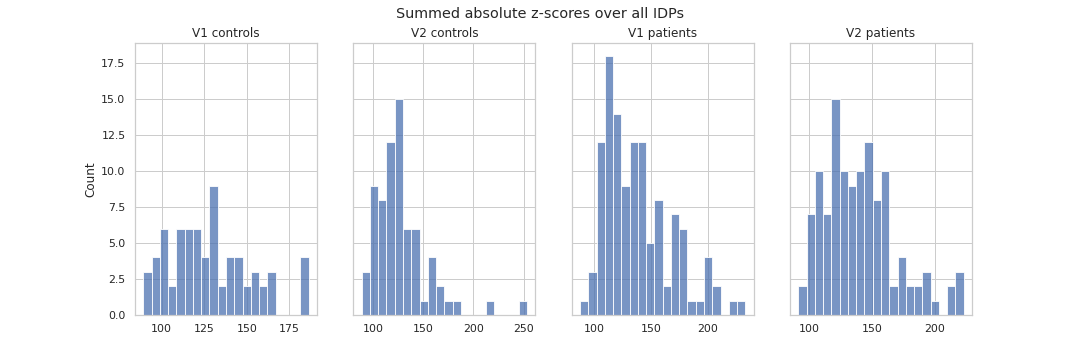

In [70]:
# Identifying controls with the high degree of variability
# To help QC
pk = np.array([np.sum(abs(v1_cont.iloc[:,col_comp_id]), axis=1).to_numpy().T, 
np.sum(abs(v2_cont.iloc[:,col_comp_id]), axis=1).to_numpy().T, 
np.sum(abs(v1_pat.iloc[:,col_comp_id]), axis=1).to_numpy().T,
np.sum(abs(v2_pat.iloc[:,col_comp_id]), axis=1).to_numpy().T], dtype=object)

fig, ax = plt.subplots(1,4, figsize = (15,5), sharey=True)
ax[0].set_title('V1 controls')
sns.histplot(pk[0], ax = ax[0], bins = 20)
ax[1].set_title('V2 controls')
sns.histplot(pk[1], ax = ax[1], bins = 20)
ax[2].set_title('V1 patients')
sns.histplot(pk[2], ax = ax[2], bins = 20)
ax[3].set_title('V2 patients')
sns.histplot(pk[3], ax = ax[3], bins = 20)

fig.suptitle('Summed absolute z-scores over all IDPs')
#sns.heatmap(v1_cont_z)
plt.savefig(os.path.join(models_dir, 'QC_hist.png'))


In [63]:
temp = pd.DataFrame(pk[1], index = v2_cont_z.index)
temp = temp.sort_values(by=[0], ascending = False)

In [100]:
pk2 = v2_pat.iloc[np.where(v2_pat.index == 'P01618')[0],col_comp_id].T
pk2.sort_values(by='P01618', ascending=False)



,P01618
rh_S_oc-temp_lat_thickness,2.301796
rh_S_precentral-inf-part_thickness,1.867125
lh_S_circular_insula_ant_thickness,1.531620
rh_Pole_temporal_thickness,1.473296
Right-Pallidum,1.325519
...,...
Left-Inf-Lat-Vent,-1.118734
Right-Hippocampus,-1.241317
rh_S_temporal_transverse_thickness,-1.338791
rh_S_orbital_med-olfact_thickness,-1.575016


In [442]:
v1_cont.shape

(70, 193)